### Importing libraries

In [2]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import OneCycleLR
from pytorch_lightning import Trainer
import matplotlib.pyplot as plt
from lightning.pytorch import loggers as pl_loggers
import albumentations as A
import importlib
from utils import utils
from utils.utils import fabric
from utils.dataset import Dataset
import warnings

warnings.filterwarnings('ignore')

In [3]:
# Initialize
utils.set_seed(1)

### Import dataset: CIFAR10

In [4]:
batch_size = 512
dataset = Dataset('CIFAR10', batch_size=batch_size, trans_lib='albumentations')

# Add augmentations for training dataset
dataset.dt.set_transforms('train', [
    A.PadIfNeeded(min_height=40, min_width=40), #, always_apply=True
    A.RandomCrop(height=32, width=32), # , always_apply=True
    A.HorizontalFlip(),
    A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=dataset.dt.mean)
], True)

Files already downloaded and verified
Files already downloaded and verified
The mean and SD for CIFAR10 dataset are [0.49139968 0.48215841 0.44653091] and [0.24703223 0.24348513 0.26158784] respectively.
Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_loader, test_loader = dataset.get_data_loaders()

Files already downloaded and verified
Files already downloaded and verified


In [6]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
torch.mean(images), torch.std(images), torch.min(images), torch.max(images)

(tensor(-0.0090), tensor(1.0010), tensor(-1.9892), tensor(2.1268))

### Visualize input images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


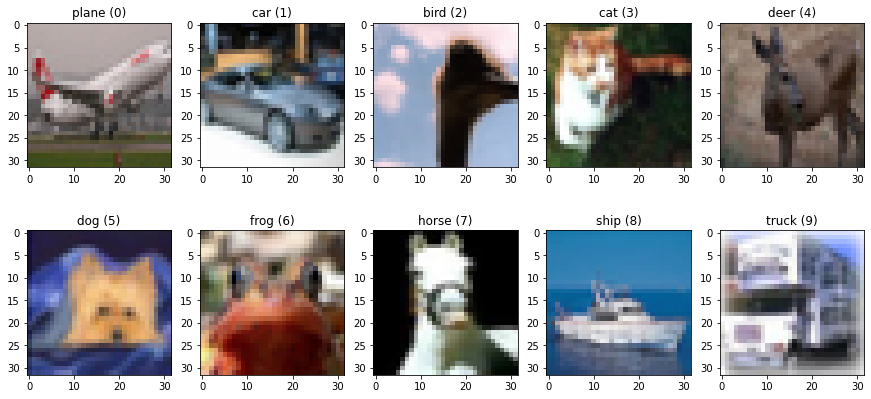

In [7]:
label_mapper = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
utils.visualize_images(images, labels, dataset.dt.mean, dataset.dt.std, label_mapper, n_cols=5, figsize=(15, 7))

### Model Training

In [8]:
from models.custom_resnet import LitCustomResNet
from models.model_composite import MetricTracker
device = utils.get_device()
in_ch = 3
model = LitCustomResNet(in_ch=in_ch).to(device)
model.print_summary(input_size=(1, in_ch, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
LitCustomResNet                          [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,728
│    └─Sequential: 2-2                   [1, 64, 32, 32]           --
│    └─BatchNorm2d: 2-3                  [1, 64, 32, 32]           128
│    └─ReLU: 2-4                         [1, 64, 32, 32]           --
├─Sequential: 1-2                        [1, 128, 16, 16]          --
│    └─Conv2d: 2-5                       [1, 128, 32, 32]          73,728
│    └─MaxPool2d: 2-6                    [1, 128, 16, 16]          --
│    └─BatchNorm2d: 2-7                  [1, 128, 16, 16]          256
│    └─ReLU: 2-8                         [1, 128, 16, 16]          --
├─Sequential: 1-3                        [1, 128, 16, 16]          --
│    └─Sequential: 2-9                   [1, 128, 16, 16]          --
│    │

### LR Finder

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.76E-01


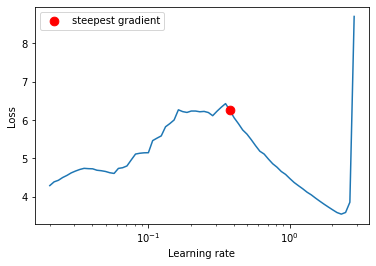

Max LR suggsted by LRFinder is 0.37649358067924693


In [12]:
num_epochs=20
steps_per_epoch=len(train_loader)
criterion = nn.CrossEntropyLoss()
kwargs = {'lr': 0.01, 'momentum': 0.9}
optimizer = utils.get_optimizer('SGD', model, **kwargs)
max_lr = utils.get_best_lr(model, train_loader, criterion, optimizer)
scheduler = OneCycleLR(
    optimizer = optimizer,
    max_lr = max_lr,
    steps_per_epoch = steps_per_epoch,
    epochs = num_epochs,
    pct_start = 5 / num_epochs,
    div_factor = 100,
    final_div_factor = 100,
    three_phase = False,
    anneal_strategy = 'linear',
    verbose = False
)

model.optimizer = optimizer
model.scheduler = scheduler
print(f'Max LR suggsted by LRFinder is {max_lr}')

%load_ext tensorboard
%tensorboard --logdir logs/

In [13]:
train_loader, test_loader = dataset.get_data_loaders()
tb_logger = pl_loggers.TensorBoardLogger(save_dir="/logs")
metric_tracker = MetricTracker()
trainer = Trainer(
    max_epochs=num_epochs,
    enable_progress_bar=True,
    logger=tb_logger,
    callbacks=[metric_tracker]
)
trainer.fit(model, train_loader, test_loader)

Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | prep_layer | Sequential | 1.9 K 
1 | layer1     | Sequential | 74.0 K
2 | residual1  | Sequential | 295 K 
3 | layer2     | Sequential | 295 K 
4 | layer3     | Sequential | 1.2 M 
5 | residual2  | Sequential | 4.7 M 
6 | pool       | MaxPool2d  | 0     
7 | flatten    | Flatten    | 0     
8 | fc         | Linear     | 5.1 K 
-----------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


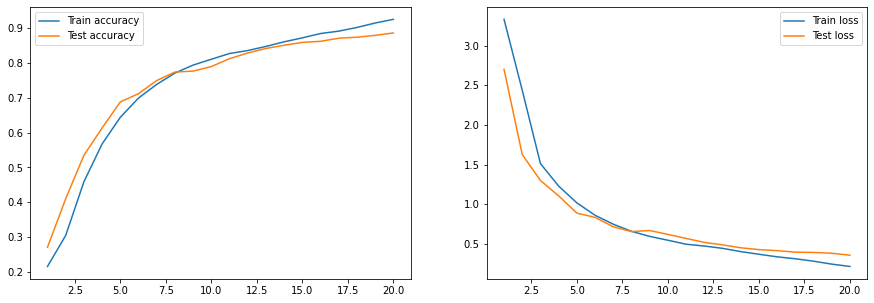

In [29]:
if len(model.train_losses) != len(model.val_losses):
    model.val_losses.pop(0)
    model.val_accuracy.pop(0)
    
plt.figure(figsize=(15, 5))
plt.subplot(121)
model.plot_accuracy()
plt.subplot(122)
model.plot_loss()
plt.savefig('images/model.png')
plt.show()

In [17]:
max(model.train_accuracy) , max(model.val_accuracy)

(0.9253000020980835, 0.8862000107765198)

### Visualizing the learning rate change across training steps

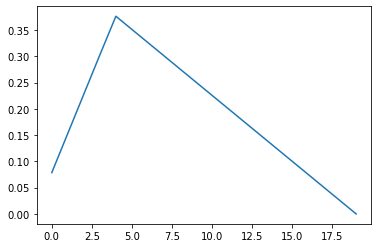

In [18]:
plt.plot(trainer.callbacks[0].lr)
plt.show()

### Visualizing incorrect predictions

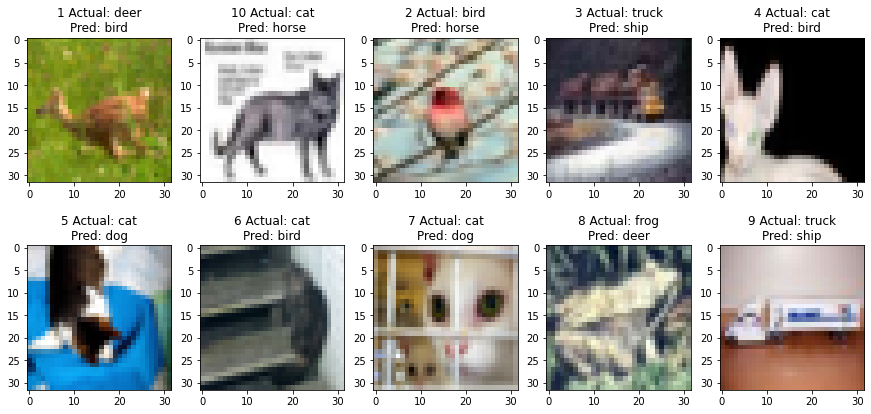

In [19]:
# from models.custom_resnet import LitCustomResNet
# model = LitCustomResNet(in_ch=3)
# model.load_state_dict(torch.load("./huggingface/model.pth", map_location=torch.device('cpu')), strict=False)
label_mapper = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
images, actual, pred = model.get_incorrect_pred('cpu', test_loader)
# images, actual, pred = images.to('cpu'), actual.to('cpu'), pred.to('cpu')
labels = [str(indx + 1) + ' Actual: %s' % label_mapper[act.item()] + '\n' + \
    'Pred: %s' % label_mapper[pr.item()] for indx, (act, pr) in enumerate(zip(actual, pred))]
utils.visualize_images(images, labels, dataset.dt.mean, dataset.dt.std, n_cols=5, figsize=(15, 7), img_title='Model predictions')
plt.savefig('images/incorrect_pred.png')

### Visualizing incorrect predictions using GradCAM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


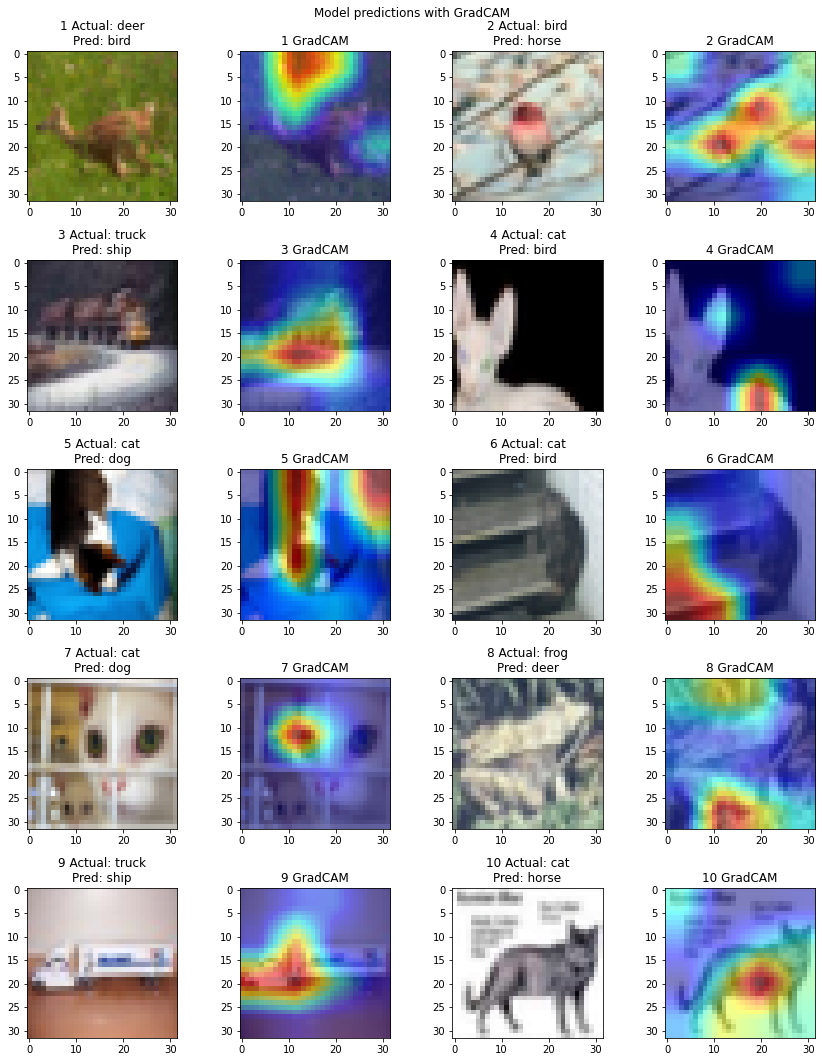

In [20]:
utils.visualize_imgs_with_gradcam(model, images, labels, pred, dataset.dt.mean, dataset.dt.std, 
    n_cols=4, figsize=(12, 15), img_title='Model predictions with GradCAM')

plt.savefig('images/incorrect_pred_with_gradcam.png')